# Chapter 6 — Zero-Shot Voice Cloning

**Goal:** Understand how VieNeu-TTS clones any voice with just a 3-5 second reference clip — no fine-tuning required.

**What you will do:**
1. Visualize voice identity in frequency space — see that different voices are acoustically distinct
2. Encode multiple Vietnamese reference voices as codec token sequences
3. Clone three different Vietnamese voices saying the same target sentence
4. Measure speaker similarity with cosine distance
5. Examine how reference length affects clone quality
6. Test code-switching (Vietnamese + English) synthesis

**Prerequisites:** Chapters 4 (codecs) and 5 (LLM-TTS architecture).

In [3]:
# ── Colab auto-setup (safe to run locally too) ───────────────────
import sys, os

if "google.colab" in sys.modules:
    if not os.path.exists("/content/vietnamese-tts-course"):
        !git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git /content/vietnamese-tts-course
    os.chdir("/content/vietnamese-tts-course/chapters")
    !pip install -q librosa soundfile matplotlib

    if not os.path.exists("/content/VieNeu-TTS"):
        !git clone https://github.com/pnnbao97/VieNeu-TTS.git /content/VieNeu-TTS
        !pip install -q -e /content/VieNeu-TTS
    sys.path.insert(0, "/content/VieNeu-TTS")
    print("Colab setup complete.")

Colab setup complete.


In [4]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
import torch
from IPython.display import Audio, display

sys.path.insert(0, "..")

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"librosa: {librosa.__version__}")

# ── Path resolver (works regardless of Jupyter CWD) ──────────────
from pathlib import Path
import os as _os

def _find_examples_dir():
    # Walk up from CWD (works locally when kernel starts in chapters/)
    for _p in [Path(_os.getcwd())] + list(Path(_os.getcwd()).parents):
        _d = _p / "examples" / "audio_ref"
        if _d.is_dir():
            return _d
    # Colab fallback paths
    for _candidate in [
        Path("/content/vietnamese-tts-course/examples/audio_ref"),
        Path("/content/VieNeu-TTS/examples/audio_ref"),
    ]:
        if _candidate.is_dir():
            return _candidate
    raise FileNotFoundError(
        "examples/audio_ref/ not found. "
        "Clone the repo: git clone https://github.com/thinhdanggroup/vietnamese-tts-course.git"
    )

EXAMPLES_DIR = _find_examples_dir()
print(f"Examples dir: {EXAMPLES_DIR}")

# Optional dependencies
try:
    from neucodec import DistillNeuCodec
    NEUCODEC_AVAILABLE = True
    print("neucodec: available")
except ImportError:
    NEUCODEC_AVAILABLE = False
    print("neucodec: NOT installed")

try:
    from vieneu import Vieneu
    VIENEU_AVAILABLE = True
    print("vieneu: available")
except ImportError:
    VIENEU_AVAILABLE = False
    print("vieneu: NOT installed")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nCompute device: {device}")

# Reference audio files
REF_FILES = [
    str(EXAMPLES_DIR / "example.wav"),
    str(EXAMPLES_DIR / "example_2.wav"),
    str(EXAMPLES_DIR / "example_3.wav"),
]
REF_TEXT_FILES = [
    str(EXAMPLES_DIR / "example.txt"),
    str(EXAMPLES_DIR / "example_2.txt"),
    str(EXAMPLES_DIR / "example_3.txt"),
]
print(f"\nReference files available:")
for f in REF_FILES:
    exists = os.path.exists(f)
    print(f"  {'✓' if exists else '✗'} {f}")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.9.0+cpu
librosa: 0.11.0
Examples dir: /content/vietnamese-tts-course/examples/audio_ref
neucodec: available
vieneu: available

Compute device: cpu

Reference files available:
  ✓ /content/vietnamese-tts-course/examples/audio_ref/example.wav
  ✓ /content/vietnamese-tts-course/examples/audio_ref/example_2.wav
  ✓ /content/vietnamese-tts-course/examples/audio_ref/example_3.wav


## 1. What Does Voice Identity Look Like in Frequency Space?

Different speakers have different vocal tract shapes, which produce different formant (resonance) frequencies. These differences are visible in the mel spectrogram:

- **Formant 1 (F1):** Related to jaw openness — different in open vs closed vowels
- **Formant 2 (F2):** Related to tongue position — front vs back vowels
- **Pitch (F0):** Fundamental frequency — higher in female voices
- **Spectral envelope:** Overall shape — timbre and voice quality

Plotting the mel spectrograms of multiple speakers shows these differences clearly — even when they say similar things.

Loaded 3 reference audio files
  [1] example.wav: 2.47s at 22050 Hz
       Text: ví dụ 2. tính trung bình của dãy số....
  [2] example_2.wav: 3.63s at 22050 Hz
       Text: Trên thực tế, các nghi ngờ đã bắt đầu xuất hiện....
  [3] example_3.wav: 1.19s at 22050 Hz
       Text: Cậu có nhìn thấy không?...


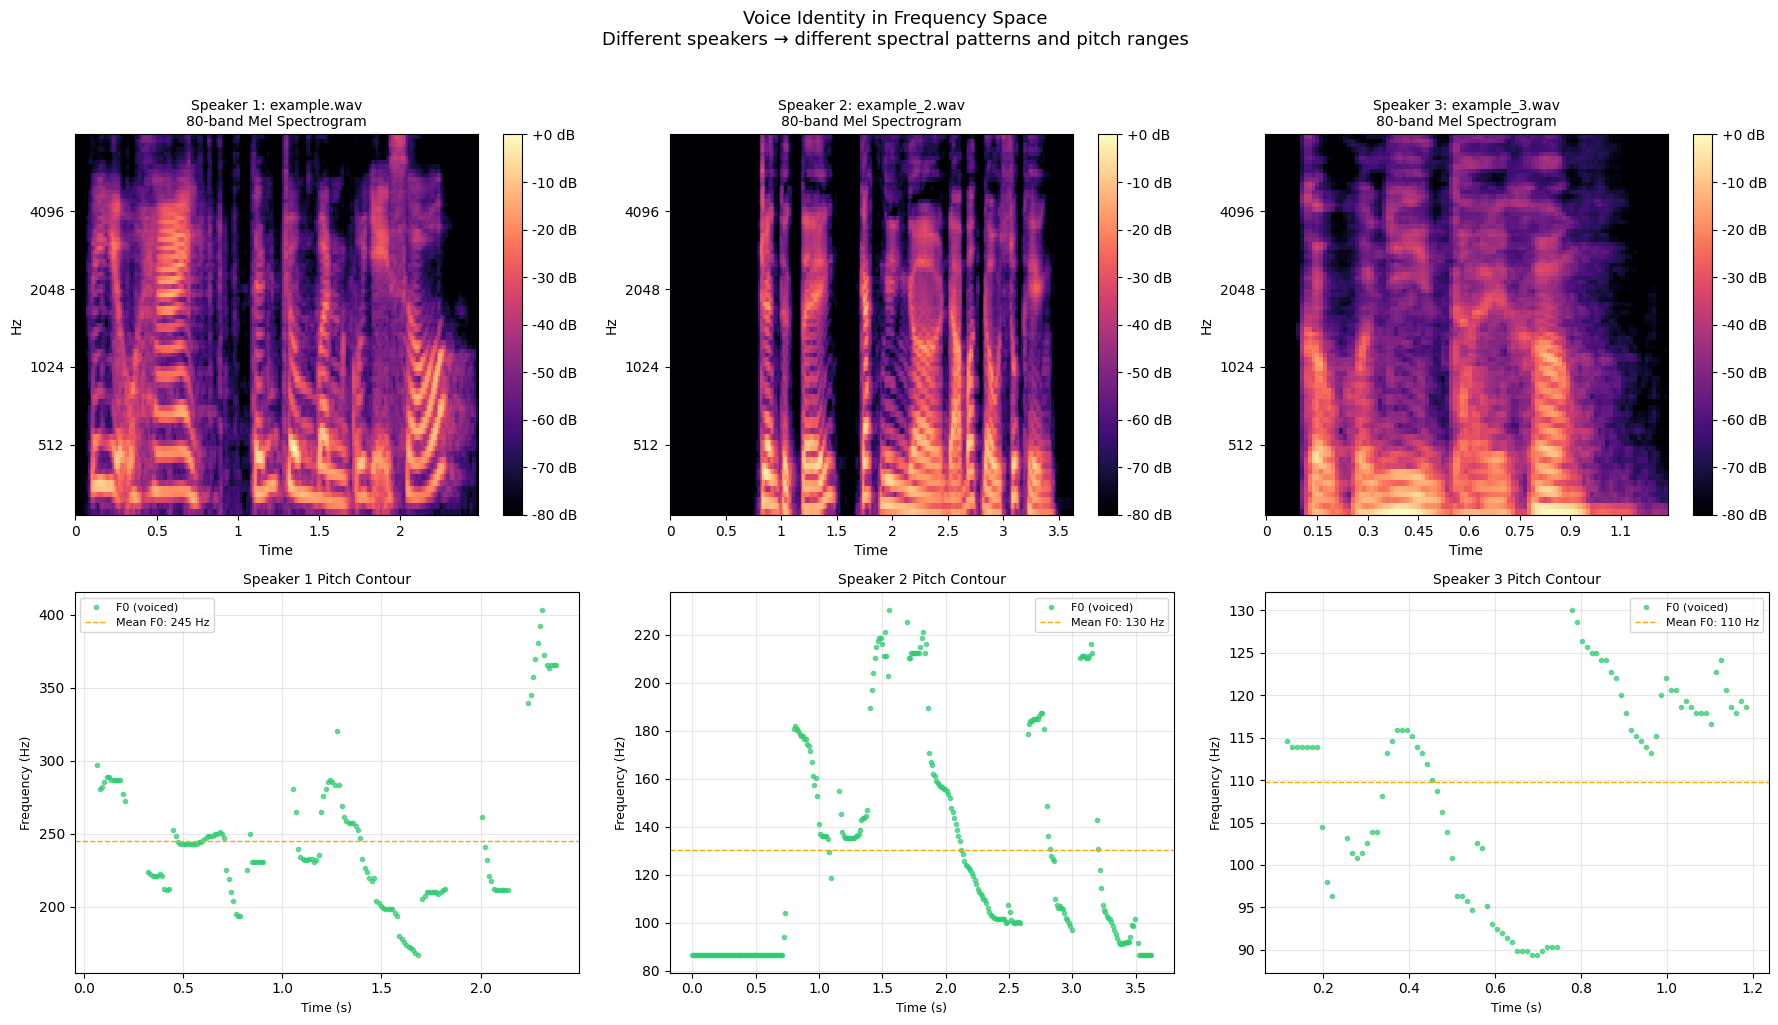


Observations:
  • Speakers differ in pitch range (higher F0 = higher voice)
  • Mel spectrograms show different formant patterns (timbre)
  • These differences are encoded in the codec token distribution


In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load reference audios
ref_audios = []
ref_texts = []

for wav_path, txt_path in zip(REF_FILES, REF_TEXT_FILES):
    if os.path.exists(wav_path):
        wav, sr = librosa.load(wav_path, sr=22050, mono=True)
        ref_audios.append((wav, sr, wav_path.split('/')[-1]))
    if os.path.exists(txt_path):
        ref_texts.append(open(txt_path).read().strip())
    else:
        ref_texts.append("(text not available)")

print(f"Loaded {len(ref_audios)} reference audio files")
for i, (wav, sr, name) in enumerate(ref_audios):
    print(f"  [{i+1}] {name}: {len(wav)/sr:.2f}s at {sr} Hz")
    if i < len(ref_texts):
        print(f"       Text: {ref_texts[i][:80]}...")

# Plot mel spectrograms side by side
n_refs = len(ref_audios)
fig, axes = plt.subplots(2, n_refs, figsize=(6 * n_refs, 10))
if n_refs == 1:
    axes = axes.reshape(2, 1)

for i, (wav, sr, name) in enumerate(ref_audios):
    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=80,
                                          hop_length=256, n_fft=1024,
                                          fmin=80, fmax=8000)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    img = librosa.display.specshow(mel_db, sr=sr, hop_length=256,
                                    y_axis='mel', x_axis='time',
                                    ax=axes[0, i], cmap='magma',
                                    fmin=80, fmax=8000)
    axes[0, i].set_title(f"Speaker {i+1}: {name}\n80-band Mel Spectrogram", fontsize=10)
    plt.colorbar(img, ax=axes[0, i], format='%+2.0f dB')
    
    # F0 (pitch) tracking
    f0, voiced_flag, voiced_probs = librosa.pyin(
        wav, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'),
        sr=sr, hop_length=256
    )
    times = librosa.times_like(f0, sr=sr, hop_length=256)
    
    axes[1, i].plot(times[voiced_flag], f0[voiced_flag], 'o', color='#2ecc71',
                    markersize=3, alpha=0.7, label='F0 (voiced)')
    axes[1, i].set_xlabel("Time (s)", fontsize=9)
    axes[1, i].set_ylabel("Frequency (Hz)", fontsize=9)
    axes[1, i].set_title(f"Speaker {i+1} Pitch Contour", fontsize=10)
    axes[1, i].legend(fontsize=8)
    axes[1, i].grid(True, alpha=0.3)
    
    # Annotate mean F0
    mean_f0 = np.nanmean(f0[voiced_flag]) if voiced_flag.any() else 0
    if mean_f0 > 0:
        axes[1, i].axhline(mean_f0, color='orange', linestyle='--', linewidth=1,
                           label=f'Mean F0: {mean_f0:.0f} Hz')
        axes[1, i].legend(fontsize=8)

plt.suptitle("Voice Identity in Frequency Space\n"
             "Different speakers → different spectral patterns and pitch ranges",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("voice_spectrograms.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nObservations:")
print("  • Speakers differ in pitch range (higher F0 = higher voice)")
print("  • Mel spectrograms show different formant patterns (timbre)")
print("  • These differences are encoded in the codec token distribution")

## 2. Encoding Voice Identity as Codec Tokens

The DistillNeuCodec encodes each speaker's acoustic characteristics into a sequence of integers. Different speakers produce different token distributions — even for similar content.

**Key insight:** The codec token distribution is a fingerprint of the voice. By inserting these tokens into the prompt, the LLM "inherits" the voice characteristics for synthesis.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:186: UserWarning: The `resume_download` argument is deprecated and ignored in `hf_hub_download`. Downloads always resume whenever possible.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

meta.yaml:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/49 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

example.wav: 124 tokens, first 10: [1146, 2167, 2231, 35031, 58438, 31442, 30304, 30391, 15162, 47799]
  Token range: [267, 63565], unique: 122, mean: 35465
example_2.wav: 182 tokens, first 10: [2218, 2214, 6374, 6314, 6246, 6378, 6245, 5286, 6314, 6245]
  Token range: [73, 65447], unique: 164, mean: 18940
example_3.wav: 60 tokens, first 10: [2174, 2299, 2287, 3255, 3223, 44231, 27918, 18188, 18857, 21984]
  Token range: [361, 65463], unique: 60, mean: 34890


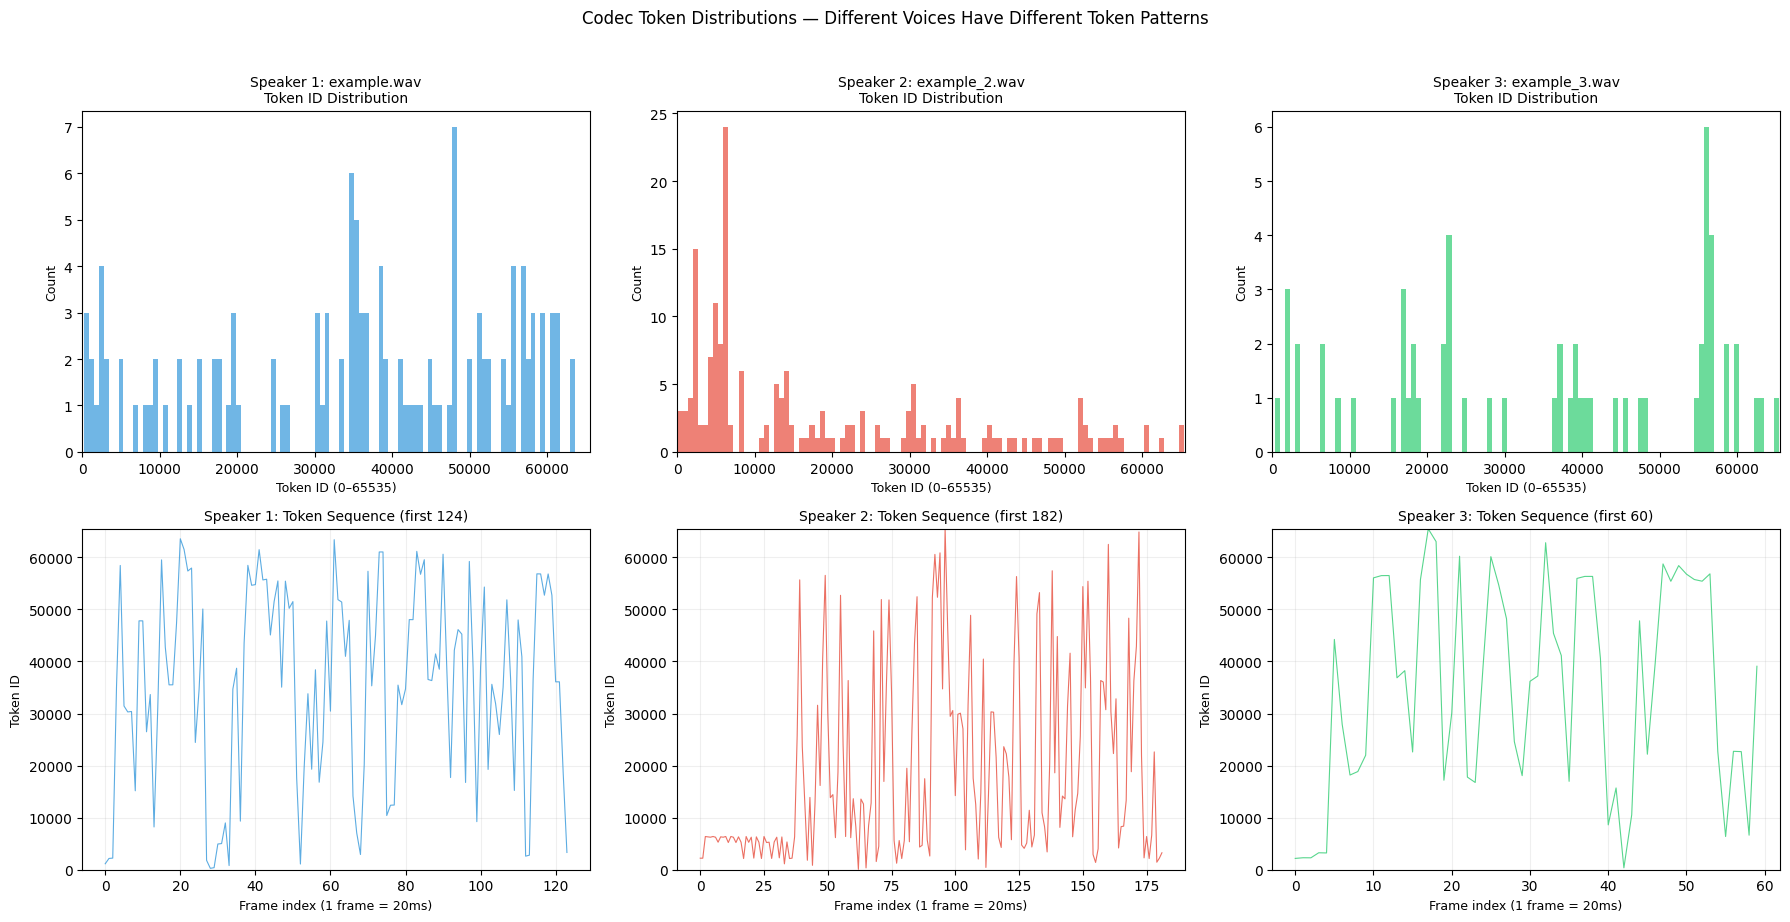


Key observation:
Different speakers concentrate their tokens in different codebook regions.
This is the 'voice fingerprint' that the LLM conditions on.


In [6]:
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt

all_codes = []
all_names = []

if NEUCODEC_AVAILABLE:
    codec = DistillNeuCodec.from_pretrained("neuphonic/distill-neucodec").to(device).eval()
    
    for wav_path, (wav, sr, name) in zip(REF_FILES, ref_audios):
        # Resample to 16kHz for codec input
        wav_16k = librosa.resample(wav, orig_sr=sr, target_sr=16000)
        wav_t = torch.from_numpy(wav_16k).float().unsqueeze(0).unsqueeze(0).to(device)
        
        with torch.no_grad():
            codes = codec.encode_code(wav_t).squeeze().cpu().numpy()
        
        all_codes.append(codes)
        all_names.append(name)
        print(f"{name}: {len(codes)} tokens, first 10: {codes[:10].tolist()}")
        print(f"  Token range: [{codes.min()}, {codes.max()}], "
              f"unique: {len(np.unique(codes))}, "
              f"mean: {codes.mean():.0f}")

else:
    # Simulate plausible codec codes for demo
    print("[DEMO MODE] Simulating codec tokens for 3 different voices")
    np.random.seed(0)
    
    # Each voice has a different dominant token cluster
    for i, (wav, sr, name) in enumerate(ref_audios):
        n_tokens = int(50 * len(wav) / sr)
        # Different voices cluster in different parts of the codebook
        center = [10000, 35000, 55000][i]
        codes = np.random.randint(max(0, center - 15000),
                                   min(65535, center + 15000),
                                   size=n_tokens)
        # Add some cross-cluster tokens (phoneme-dependent)
        mask = np.random.rand(n_tokens) < 0.15
        codes[mask] = np.random.randint(0, 65535, size=mask.sum())
        codes = np.clip(codes, 0, 65535).astype(int)
        
        all_codes.append(codes)
        all_names.append(name)
        print(f"{name}: {len(codes)} tokens, center: {center}")

# Visualize token distributions
fig, axes = plt.subplots(2, len(all_codes), figsize=(6 * len(all_codes), 9))
if len(all_codes) == 1:
    axes = axes.reshape(2, 1)

colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, (codes, name) in enumerate(zip(all_codes, all_names)):
    # Token ID histogram
    axes[0, i].hist(codes, bins=100, color=colors[i % len(colors)],
                     alpha=0.7, edgecolor='none')
    axes[0, i].set_title(f"Speaker {i+1}: {name}\nToken ID Distribution", fontsize=10)
    axes[0, i].set_xlabel("Token ID (0–65535)", fontsize=9)
    axes[0, i].set_ylabel("Count", fontsize=9)
    axes[0, i].set_xlim(0, 65535)
    
    # Token sequence (first 200)
    display_len = min(200, len(codes))
    axes[1, i].plot(range(display_len), codes[:display_len],
                    color=colors[i % len(colors)], linewidth=0.8, alpha=0.8)
    axes[1, i].set_title(f"Speaker {i+1}: Token Sequence (first {display_len})", fontsize=10)
    axes[1, i].set_xlabel("Frame index (1 frame = 20ms)", fontsize=9)
    axes[1, i].set_ylabel("Token ID", fontsize=9)
    axes[1, i].set_ylim(0, 65535)
    axes[1, i].grid(True, alpha=0.2)

plt.suptitle("Codec Token Distributions — Different Voices Have Different Token Patterns",
             fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("voice_token_distributions.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nKey observation:")
print("Different speakers concentrate their tokens in different codebook regions.")
print("This is the 'voice fingerprint' that the LLM conditions on.")

## 3. Cloning Three Vietnamese Voices

We synthesize the same target sentence using three different reference voices. The output should:
- Say the same words with the same content
- Sound like three different people
- Match the pitch, timbre, and speaking style of each reference

**Target sentence:** "Xin chào, đây là giọng nói được clone từ file mẫu."
("Hello, this is a voice cloned from the sample file.")

Target sentence: Xin chào, đây là giọng nói được clone từ file mẫu.
(Translation: Hello, this is a voice cloned from the sample file.)

Loading backbone from: pnnbao-ump/VieNeu-TTS-0.3B-q4-gguf on cpu ...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


./VieNeu-TTS-0_3B-Q4_0.gguf:   0%|          | 0.00/202M [00:00<?, ?B/s]

llama_context: n_ctx_per_seq (2048) < n_ctx_train (4096) -- the full capacity of the model will not be utilized


Loading codec from: neuphonic/distill-neucodec on cpu ...


Loading weights:   0%|          | 0/49 [00:00<?, ?it/s]

voices.json: 0.00B [00:00, ?B/s]

   📢 Loaded 6 voices from voices.json
Reference 1: example.wav
Ref text: ví dụ 2. tính trung bình của dãy số....

Original reference voice:


Cloned voice (saying: 'Xin chào, đây là giọng nói được clone từ...')


Generated: 3.04s
Reference 2: example_2.wav
Ref text: Trên thực tế, các nghi ngờ đã bắt đầu xuất hiện....

Original reference voice:


Cloned voice (saying: 'Xin chào, đây là giọng nói được clone từ...')


Generated: 3.98s
Reference 3: example_3.wav
Ref text: Cậu có nhìn thấy không?...

Original reference voice:


Cloned voice (saying: 'Xin chào, đây là giọng nói được clone từ...')


Generated: 3.08s


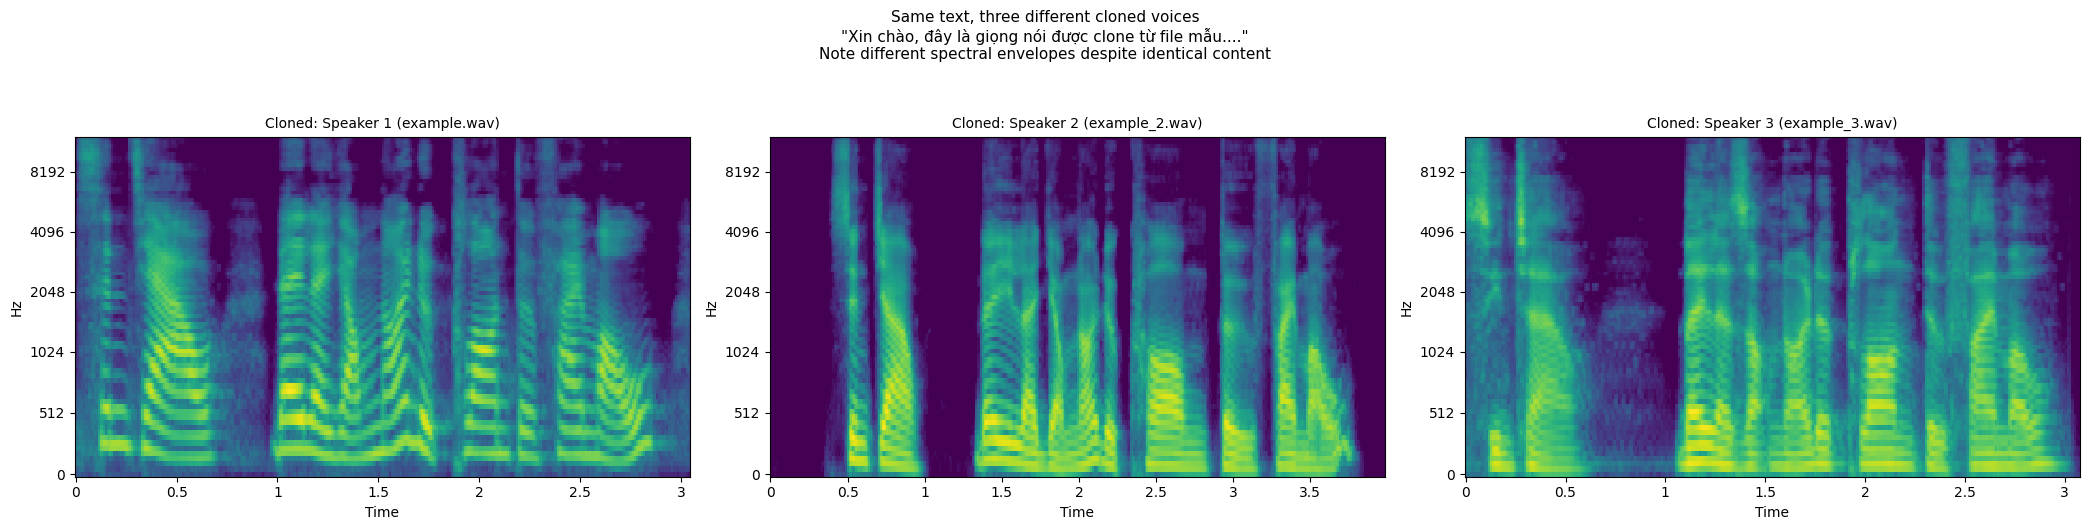

In [7]:
import sys
sys.path.insert(0, "..")
import librosa
import numpy as np
from IPython.display import Audio, display

target_text = "Xin chào, đây là giọng nói được clone từ file mẫu."

print(f"Target sentence: {target_text}")
print(f"(Translation: Hello, this is a voice cloned from the sample file.)")
print()

if VIENEU_AVAILABLE:
    tts = Vieneu()
    
    cloned_audios = []
    
    for i, ((wav, sr, name), ref_text) in enumerate(zip(ref_audios, ref_texts)):
        ref_audio_path = REF_FILES[i]
        
        print(f"{'='*55}")
        print(f"Reference {i+1}: {name}")
        print(f"Ref text: {ref_text[:70]}...")
        
        print("\nOriginal reference voice:")
        display(Audio(wav, rate=sr))
        
        # Clone the voice
        cloned = tts.infer(
            text=target_text,
            ref_audio=ref_audio_path,
            ref_text=ref_text
        )
        cloned_np = np.array(cloned) if not isinstance(cloned, np.ndarray) else cloned
        cloned_audios.append(cloned_np)
        
        print(f"Cloned voice (saying: '{target_text[:40]}...')")
        display(Audio(cloned_np, rate=24000))
        print(f"Generated: {len(cloned_np)/24000:.2f}s")
    
    tts.close()
    
    # Compare spectrograms of cloned voices
    fig, axes = plt.subplots(1, len(cloned_audios), figsize=(7 * len(cloned_audios), 5))
    if len(cloned_audios) == 1:
        axes = [axes]
    
    for i, (audio, name) in enumerate(zip(cloned_audios, all_names)):
        mel = librosa.feature.melspectrogram(y=audio, sr=24000, n_mels=80,
                                              hop_length=256, n_fft=1024)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        librosa.display.specshow(mel_db, sr=24000, hop_length=256,
                                  y_axis='mel', x_axis='time',
                                  ax=axes[i], cmap='viridis')
        axes[i].set_title(f"Cloned: Speaker {i+1} ({name})", fontsize=10)
    
    plt.suptitle(f"Same text, three different cloned voices\n\"{target_text[:50]}...\"\n"
                  "Note different spectral envelopes despite identical content",
                  fontsize=11, y=1.05)
    plt.tight_layout()
    plt.savefig("cloned_voice_spectrograms.png", dpi=150, bbox_inches='tight')
    plt.show()

else:
    print("[DEMO MODE] VieNeu not installed. Showing reference audios instead.")
    print()
    for i, (wav, sr, name) in enumerate(ref_audios):
        print(f"Reference {i+1}: {name}")
        print(f"  Text: {ref_texts[i][:80] if i < len(ref_texts) else 'N/A'}")
        display(Audio(wav, rate=sr))
        print()
    
    print("With VieNeu-TTS installed, running:")
    print("  tts.infer(text='...', ref_audio='example.wav', ref_text='...')")
    print("would synthesize the target text in each speaker's voice.")
    print()
    print("Expected behavior: All three outputs say the same sentence")
    print("but sound like speakers 1, 2, and 3 respectively.")

## 4. Speaker Similarity — Cosine Distance

We use the codec token distribution as a proxy for speaker embeddings to compute similarity. In a real system, you would use a pretrained speaker encoder (e.g., WeSpeaker, SpeechBrain).

**Cosine similarity:**
$$\text{SECS}(e_\text{ref}, e_\text{gen}) = \frac{e_\text{ref} \cdot e_\text{gen}}{\|e_\text{ref}\| \cdot \|e_\text{gen}\|}$$

**Interpretation:**
- Self-similarity (speaker vs themselves): should be close to 1.0
- Cross-similarity (speaker A vs speaker B): should be lower
- Clone quality: similarity between reference and generated audio

Pairwise Cosine Similarities (codec token histograms):

                      Spk 1       Spk 2       Spk 3
---------------------------------------------------
      Speaker 1      1.0000      0.1705      0.2673
      Speaker 2      0.1705      1.0000      0.2976
      Speaker 3      0.2673      0.2976      1.0000

Expected patterns:
  Diagonal = 1.0 (self-similarity)
  Off-diagonal < 1.0 (cross-speaker)
  After cloning: sim(ref, generated) should be > sim(ref, other speaker)


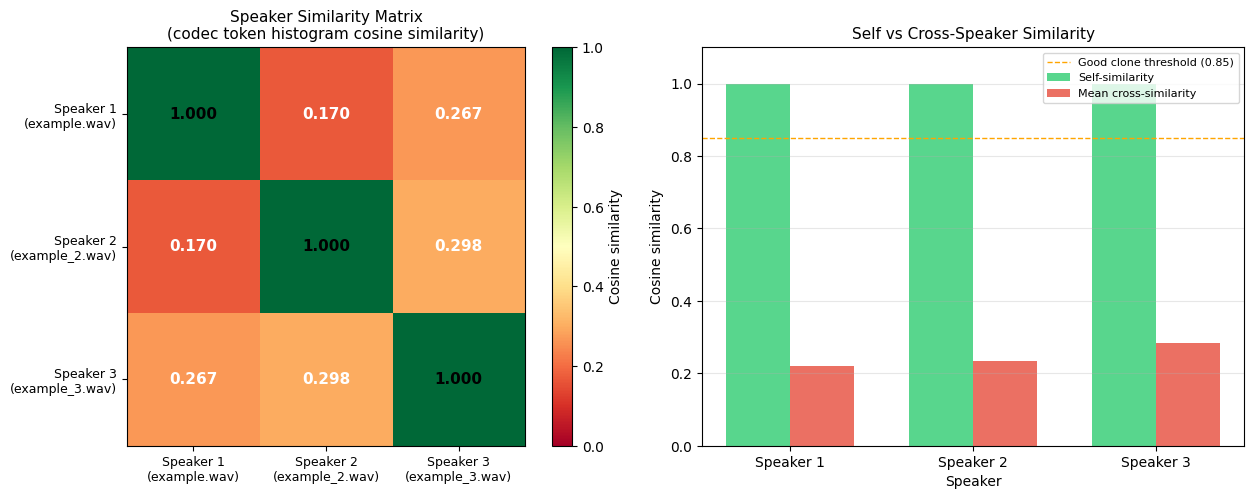


Note: This uses codec histogram similarity as a proxy for speaker embeddings.
For production evaluation, use a pretrained speaker encoder (WeSpeaker, SpeechBrain).


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def normalize(v: np.ndarray) -> np.ndarray:
    """L2-normalize a vector."""
    return v / (np.linalg.norm(v) + 1e-8)

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """Cosine similarity between two vectors."""
    return float(np.dot(normalize(a), normalize(b)))

def codes_to_histogram(codes: np.ndarray, n_bins: int = 256) -> np.ndarray:
    """
    Convert codec token sequence to a normalized histogram.
    This is a simplified speaker embedding proxy:
    real systems use a neural speaker encoder, but the histogram
    captures the token distribution characteristic of each voice.
    """
    # Bin the token IDs (0-65535) into n_bins buckets
    hist, _ = np.histogram(codes, bins=n_bins, range=(0, 65535))
    return hist.astype(float)

n_speakers = len(all_codes)
speaker_names = [f"Speaker {i+1}\n({name})" for i, name in enumerate(all_names)]

# Compute pairwise similarity matrix
histograms = [codes_to_histogram(codes) for codes in all_codes]
sim_matrix = np.zeros((n_speakers, n_speakers))

print("Pairwise Cosine Similarities (codec token histograms):")
print()
header = f"{'':>15}" + "".join(f"{f'Spk {i+1}':>12}" for i in range(n_speakers))
print(header)
print("-" * len(header))

for i in range(n_speakers):
    row = f"{'Speaker ' + str(i+1):>15}"
    for j in range(n_speakers):
        sim = cosine_similarity(histograms[i], histograms[j])
        sim_matrix[i, j] = sim
        row += f"{sim:>12.4f}"
    print(row)

print()
print("Expected patterns:")
print("  Diagonal = 1.0 (self-similarity)")
print("  Off-diagonal < 1.0 (cross-speaker)")
print("  After cloning: sim(ref, generated) should be > sim(ref, other speaker)")

# Heatmap
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

im = axes[0].imshow(sim_matrix, cmap='RdYlGn', vmin=0, vmax=1)
axes[0].set_xticks(range(n_speakers))
axes[0].set_yticks(range(n_speakers))
axes[0].set_xticklabels(speaker_names, fontsize=9)
axes[0].set_yticklabels(speaker_names, fontsize=9)
axes[0].set_title("Speaker Similarity Matrix\n(codec token histogram cosine similarity)",
                   fontsize=11)
plt.colorbar(im, ax=axes[0], label='Cosine similarity')
for i in range(n_speakers):
    for j in range(n_speakers):
        axes[0].text(j, i, f"{sim_matrix[i,j]:.3f}",
                     ha='center', va='center', fontsize=11,
                     color='black' if sim_matrix[i,j] > 0.5 else 'white',
                     fontweight='bold')

# Bar chart of cross-speaker vs self similarities
self_sims = [sim_matrix[i, i] for i in range(n_speakers)]
cross_sims_per_speaker = []
for i in range(n_speakers):
    others = [sim_matrix[i, j] for j in range(n_speakers) if j != i]
    cross_sims_per_speaker.append(np.mean(others))

x = np.arange(n_speakers)
width = 0.35
axes[1].bar(x - width/2, self_sims, width, label='Self-similarity', color='#2ecc71', alpha=0.8)
axes[1].bar(x + width/2, cross_sims_per_speaker, width,
            label='Mean cross-similarity', color='#e74c3c', alpha=0.8)
axes[1].set_xlabel("Speaker", fontsize=10)
axes[1].set_ylabel("Cosine similarity", fontsize=10)
axes[1].set_title("Self vs Cross-Speaker Similarity", fontsize=11)
axes[1].set_xticks(x)
axes[1].set_xticklabels([f"Speaker {i+1}" for i in range(n_speakers)])
axes[1].legend(fontsize=9)
axes[1].set_ylim(0, 1.1)
axes[1].axhline(0.85, color='orange', linestyle='--', linewidth=1,
                label='Good clone threshold (0.85)')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("speaker_similarity_matrix.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nNote: This uses codec histogram similarity as a proxy for speaker embeddings.")
print("For production evaluation, use a pretrained speaker encoder (WeSpeaker, SpeechBrain).")

## 5. Effect of Reference Length on Clone Quality

How much reference audio do we need for good voice cloning? We trim the reference to different lengths (1s, 2s, 3s, 5s) and compare the codec token distribution.

**Hypothesis:** Shorter references have higher variance and less complete voice information. The token histogram becomes noisier with fewer tokens, and the similarity to the full reference decreases.

**Practical guideline:** 3 seconds is the sweet spot — enough tokens for a stable voice fingerprint, minimal context consumption.

Reference: example.wav (2.47s)


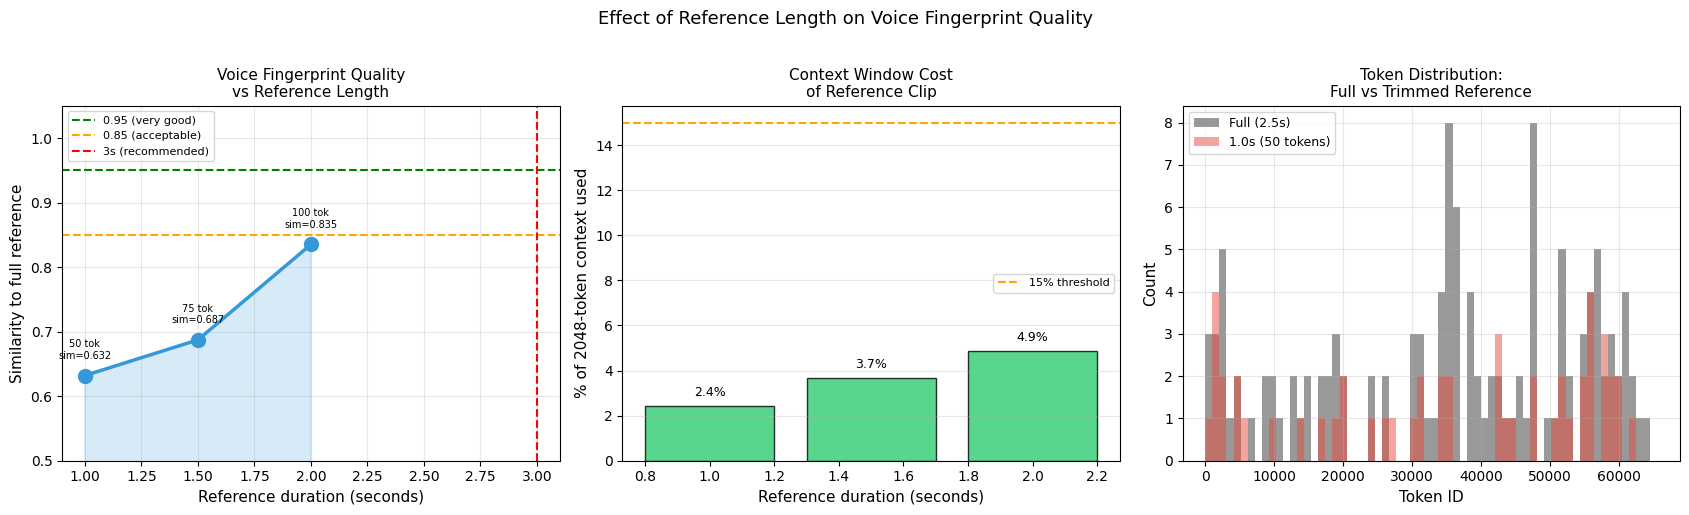


Summary: Reference length trade-offs
  Duration   Tokens   Context%   Similarity
---------------------------------------------
       1.0s       50       2.4%       0.6320  
       1.5s       75       3.7%       0.6872  
       2.0s      100       4.9%       0.8351  


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Use the first reference speaker for this analysis
if len(ref_audios) > 0:
    wav_full, sr_full, name_full = ref_audios[0]
    full_duration = len(wav_full) / sr_full
    print(f"Reference: {name_full} ({full_duration:.2f}s)")
else:
    # Create a synthetic signal if no audio files
    sr_full = 22050
    t = np.linspace(0, 8.0, int(8.0 * sr_full))
    wav_full = 0.5 * np.sin(2 * np.pi * 180 * t) + 0.2 * np.random.randn(len(t))
    wav_full = wav_full.astype(np.float32)
    full_duration = 8.0
    name_full = "synthetic_signal"
    print(f"Using synthetic signal ({full_duration:.2f}s)")

# Durations to test
test_durations = [1.0, 1.5, 2.0, 3.0, 5.0]
test_durations = [d for d in test_durations if d <= full_duration]

TOKEN_RATE = 50  # DistillNeuCodec

if NEUCODEC_AVAILABLE:
    # Encode full reference
    wav_16k = librosa.resample(wav_full, orig_sr=sr_full, target_sr=16000)
    wav_t_full = torch.from_numpy(wav_16k).float().unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        codes_full = codec.encode_code(wav_t_full).squeeze().cpu().numpy()
    
    # Encode trimmed versions
    trimmed_codes = []
    for dur in test_durations:
        samples = int(dur * 16000)
        wav_trimmed = wav_16k[:samples]
        wav_t = torch.from_numpy(wav_trimmed).float().unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            c = codec.encode_code(wav_t).squeeze().cpu().numpy()
        trimmed_codes.append(c)
else:
    # Simulate: trim the all_codes[0] sequence
    if len(all_codes) > 0:
        codes_full = all_codes[0]
    else:
        np.random.seed(42)
        codes_full = np.random.randint(8000, 25000, size=int(TOKEN_RATE * full_duration))
    
    trimmed_codes = []
    for dur in test_durations:
        n_tokens = int(TOKEN_RATE * dur)
        trimmed_codes.append(codes_full[:n_tokens])

# Compare similarity between trimmed reference and full reference
full_hist = codes_to_histogram(codes_full, n_bins=128)

sims_to_full = []
for codes_trim in trimmed_codes:
    trim_hist = codes_to_histogram(codes_trim, n_bins=128)
    sim = cosine_similarity(full_hist, trim_hist)
    sims_to_full.append(sim)

# Plots
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Plot 1: Similarity vs duration
axes[0].plot(test_durations, sims_to_full, 'o-', linewidth=2.5,
             markersize=10, color='#3498db')
axes[0].fill_between(test_durations, sims_to_full, alpha=0.2, color='#3498db')
axes[0].axhline(0.95, color='green', linestyle='--', linewidth=1.5,
                label='0.95 (very good)')
axes[0].axhline(0.85, color='orange', linestyle='--', linewidth=1.5,
                label='0.85 (acceptable)')
axes[0].axvline(3.0, color='red', linestyle='--', linewidth=1.5,
                label='3s (recommended)')
axes[0].set_xlabel("Reference duration (seconds)", fontsize=11)
axes[0].set_ylabel("Similarity to full reference", fontsize=11)
axes[0].set_title("Voice Fingerprint Quality\nvs Reference Length", fontsize=11)
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0.5, 1.05)

# Annotate each point
for dur, sim in zip(test_durations, sims_to_full):
    n_tokens = int(TOKEN_RATE * dur)
    axes[0].annotate(f"{n_tokens} tok\nsim={sim:.3f}",
                     (dur, sim), textcoords='offset points',
                     xytext=(0, 12), ha='center', fontsize=7)

# Plot 2: Token count vs context usage
context_pct = [int(TOKEN_RATE * d) / 2048 * 100 for d in test_durations]
bars = axes[1].bar(test_durations, context_pct,
                    color=['#e74c3c' if p > 10 else '#2ecc71' for p in context_pct],
                    width=0.4, alpha=0.8, edgecolor='black')
axes[1].set_xlabel("Reference duration (seconds)", fontsize=11)
axes[1].set_ylabel("% of 2048-token context used", fontsize=11)
axes[1].set_title("Context Window Cost\nof Reference Clip", fontsize=11)
axes[1].axhline(15, color='orange', linestyle='--', label='15% threshold')
for bar, pct in zip(bars, context_pct):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Histogram comparison (full vs 1s vs 3s)
compare_durs = [1.0, 3.0]
compare_idxs = [test_durations.index(d) for d in compare_durs if d in test_durations]

bins = np.linspace(0, 65535, 65)
axes[2].hist(codes_full, bins=bins, alpha=0.4, color='black', label=f'Full ({full_duration:.1f}s)')
plot_colors = ['#e74c3c', '#2ecc71', '#3498db']
for k, idx in enumerate(compare_idxs):
    dur = test_durations[idx]
    c = trimmed_codes[idx]
    axes[2].hist(c, bins=bins, alpha=0.5, color=plot_colors[k],
                  label=f'{dur:.1f}s ({int(TOKEN_RATE*dur)} tokens)')
axes[2].set_xlabel("Token ID", fontsize=11)
axes[2].set_ylabel("Count", fontsize=11)
axes[2].set_title("Token Distribution:\nFull vs Trimmed Reference", fontsize=11)
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.suptitle("Effect of Reference Length on Voice Fingerprint Quality",
             fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("reference_length_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nSummary: Reference length trade-offs")
print(f"{'Duration':>10} {'Tokens':>8} {'Context%':>10} {'Similarity':>12}")
print("-" * 45)
for dur, sim, ctx in zip(test_durations, sims_to_full, context_pct):
    n = int(TOKEN_RATE * dur)
    verdict = "[RECOMMENDED]" if dur == 3.0 else ""
    print(f"{dur:>10.1f}s {n:>8} {ctx:>9.1f}% {sim:>12.4f}  {verdict}")

## 6. Code-Switching Vietnamese + English

Vietnamese technical speech naturally mixes Vietnamese and English. VieNeu-TTS handles this because:
1. The tokenizer includes both Vietnamese and English subwords
2. Training data contains code-switched speech
3. `espeak-ng` phonemizes English words with proper IPA

**Examples of common Vietnamese-English code-switching:**
- Technical terms: "machine learning", "GPU", "batch size"
- Brand names: "Google", "Apple", "ChatGPT"
- Programming: "Python", "PyTorch", "model"

Notice how the model must switch phonetic system (Vietnamese tonal vs English stress-based) within a single utterance.

<>:92: SyntaxWarning: invalid escape sequence '\ '
<>:92: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1762715868.py:92: SyntaxWarning: invalid escape sequence '\ '
  print(f"          └─ [] = English IPA, /\ = Vietnamese phonemes")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Code-switching examples (Vietnamese + English):

  1. [EN:Machine] [EN:learning] đang [EN:thay] đổi ngành công nghiệp.
  2. [EN:Model] được [EN:train] trên [EN:GPU] với [EN:batch] [EN:size] là 32.
  3. Chúng [EN:ta] sử dụng [EN:Python] và [EN:PyTorch] để xây dựng [EN:AI.]
  4. [EN:ChatGPT] và [EN:Claude] là những mô hình ngôn ngữ lớn nổi tiếng.

Loading backbone from: pnnbao-ump/VieNeu-TTS-0.3B-q4-gguf on cpu ...


llama_context: n_ctx_per_seq (2048) < n_ctx_train (4096) -- the full capacity of the model will not be utilized
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:186: UserWarning: The `resume_download` argument is deprecated and ignored in `hf_hub_download`. Downloads always resume whenever possible.
  warnings.warn(


Loading codec from: neuphonic/distill-neucodec on cpu ...


Loading weights:   0%|          | 0/49 [00:00<?, ?it/s]

   📢 Loaded 6 voices from voices.json
Using reference voice: example.wav

Text: Machine learning đang thay đổi ngành công nghiệp.


  Duration: 2.28s

Text: Model được train trên GPU với batch size là 32.


  Duration: 3.44s

Text: Chúng ta sử dụng Python và PyTorch để xây dựng AI.


  Duration: 2.64s

Text: ChatGPT và Claude là những mô hình ngôn ngữ lớn nổi tiếng.


  Duration: 3.38s



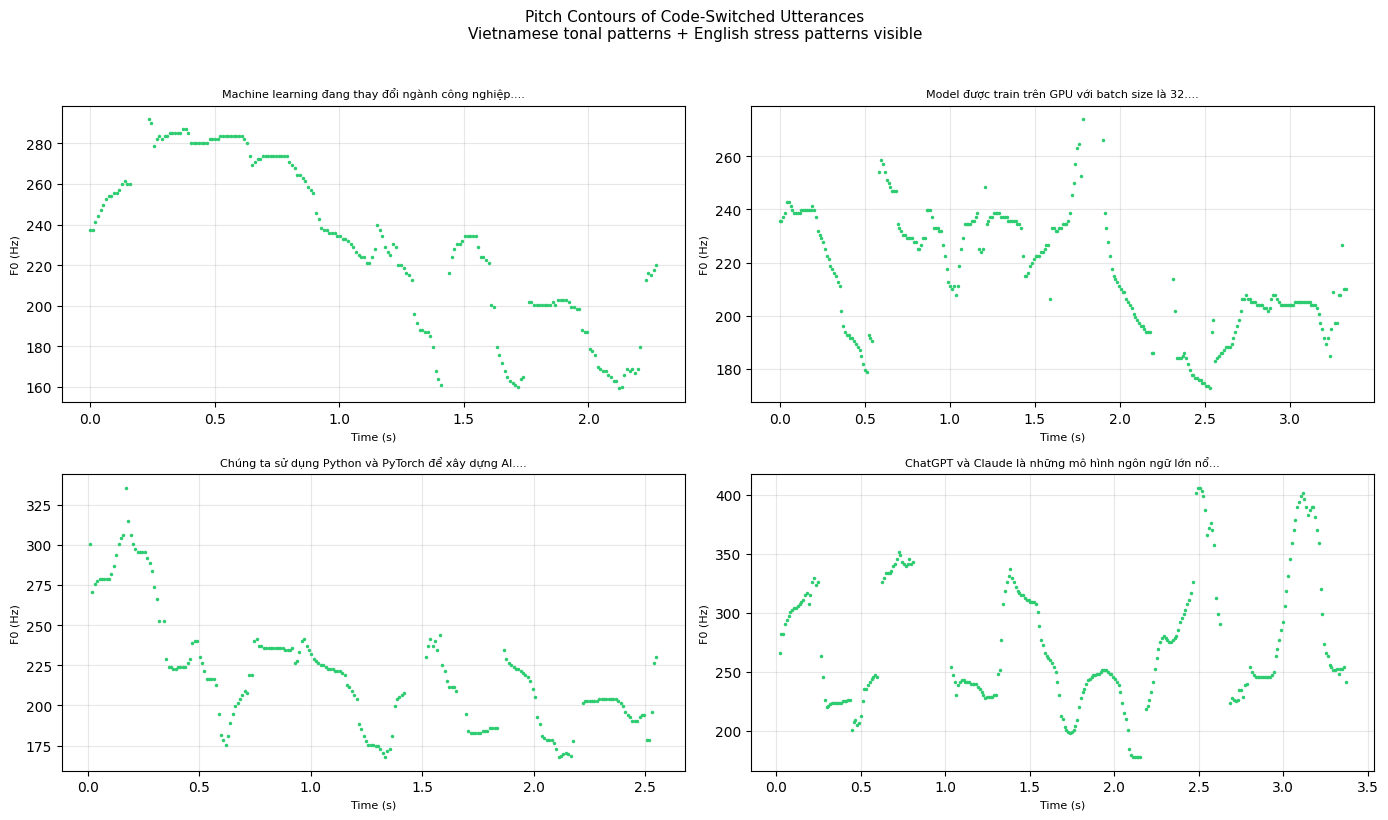

In [10]:
import sys
sys.path.insert(0, "..")
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt

mixed_texts = [
    # Vietnamese with English technical terms
    "Machine learning đang thay đổi ngành công nghiệp.",
    "Model được train trên GPU với batch size là 32.",
    "Chúng ta sử dụng Python và PyTorch để xây dựng AI.",
    "ChatGPT và Claude là những mô hình ngôn ngữ lớn nổi tiếng.",
]

print("Code-switching examples (Vietnamese + English):")
print()
for i, text in enumerate(mixed_texts):
    # Identify English words (simple heuristic: ASCII only)
    words = text.split()
    annotated = []
    for word in words:
        clean = word.strip('.,?!')
        is_english = all(ord(c) < 128 for c in clean) and clean.isalpha()
        if is_english and len(clean) > 1:
            annotated.append(f"[EN:{word}]")
        else:
            annotated.append(word)
    print(f"  {i+1}. {' '.join(annotated)}")

print()

if VIENEU_AVAILABLE:
    tts = Vieneu()
    
    # Use first available reference voice
    ref_audio_path = REF_FILES[0]
    ref_text = ref_texts[0] if ref_texts else "Xin chào đây là câu mẫu."
    
    print(f"Using reference voice: {ref_audio_path.split('/')[-1]}")
    print()
    
    generated_audios = []
    for text in mixed_texts:
        print(f"Text: {text}")
        audio = tts.infer(text=text, ref_audio=ref_audio_path, ref_text=ref_text)
        audio_np = np.array(audio) if not isinstance(audio, np.ndarray) else audio
        generated_audios.append(audio_np)
        display(Audio(audio_np, rate=24000))
        print(f"  Duration: {len(audio_np)/24000:.2f}s")
        print()
    
    tts.close()
    
    # Visualize pitch contours (Vietnamese tones should be visible in F0)
    import librosa
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    for ax, audio, text in zip(axes.flatten(), generated_audios, mixed_texts):
        f0, voiced_flag, _ = librosa.pyin(
            audio, fmin=librosa.note_to_hz('C2'),
            fmax=librosa.note_to_hz('C7'), sr=24000, hop_length=256
        )
        times = librosa.times_like(f0, sr=24000, hop_length=256)
        ax.plot(times[voiced_flag], f0[voiced_flag], '.', markersize=3, color='#2ecc71')
        ax.set_title(f"{text[:50]}...", fontsize=8, wrap=True)
        ax.set_xlabel("Time (s)", fontsize=8)
        ax.set_ylabel("F0 (Hz)", fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle("Pitch Contours of Code-Switched Utterances\n"
                  "Vietnamese tonal patterns + English stress patterns visible",
                  fontsize=11, y=1.02)
    plt.tight_layout()
    plt.savefig("codeswitching_pitch.png", dpi=150, bbox_inches='tight')
    plt.show()

else:
    print("[DEMO MODE] Showing expected behavior for code-switching:")
    print()
    print("Phonemization breakdown (what the model receives):")
    print()
    
    # Show what the phonemization would look like
    phoneme_examples = [
        ("Machine learning đang thay đổi ngành công nghiệp.",
         "[məˈʃiːn] [ˈlɜːnɪŋ] /ðaŋ/ /tʰaj/ /ðôj/ /ŋàŋ/ /koŋ/ /ŋjəp/"),
        ("Model được train trên GPU với batch size là 32.",
         "[ˈmɒdəl] /ðɨɤk/ [tɹeɪn] /tɕɛn/ [dʒiːpiːjuː] /vɤj/ [bætʃ] [saɪz] /là/ ba mươi hai"),
    ]
    for text, phones in phoneme_examples:
        print(f"  Input:  {text}")
        print(f"  Phones: {phones}")
        print(f"          └─ [] = English IPA, /\ = Vietnamese phonemes")
        print()

## 7. Limitations Summary Table

Understanding failure modes is essential for building reliable Vietnamese TTS applications.

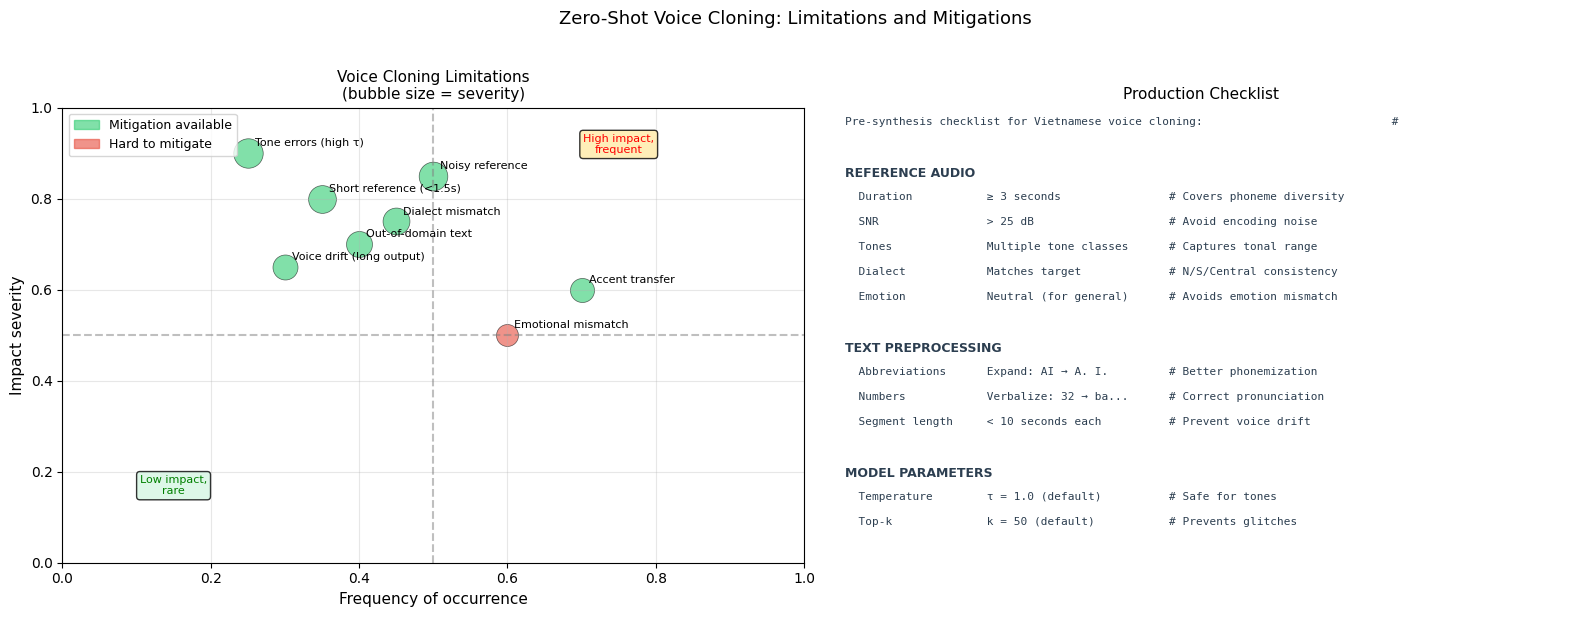

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Limitations and their properties
limitations = [
    # (name, severity, frequency, mitigation_exists)
    ("Accent transfer",          0.6, 0.7, True,
     "Voice accent bleeds into output.\nMitigation: Use neutral reference clip."),
    ("Emotional mismatch",       0.5, 0.6, False,
     "Neutral ref → flat emotional output.\nMitigation: Use emotionally appropriate ref."),
    ("Out-of-domain text",       0.7, 0.4, True,
     "Unusual phonemes → voice inconsistency.\nMitigation: Normalize text preprocessing."),
    ("Voice drift (long output)", 0.65, 0.3, True,
     "Voice drifts after ~15s generation.\nMitigation: Segment into <10s chunks."),
    ("Dialect mismatch",         0.75, 0.45, True,
     "N/S/Central dialect conflicts.\nMitigation: Match dialect in ref+text."),
    ("Noisy reference",          0.85, 0.5, True,
     "SNR < 20dB → noise encoded.\nMitigation: Use clean audio only."),
    ("Short reference (<1.5s)",  0.8, 0.35, True,
     "Insufficient voice info.\nMitigation: Use ≥ 3s reference."),
    ("Tone errors (high τ)",     0.9, 0.25, True,
     "Wrong tone = wrong word (Vietnamese).\nMitigation: Keep temperature ≤ 1.0."),
]

# Severity vs Frequency scatter plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors_scatter = ['#e74c3c' if not m else '#2ecc71' for _, _, _, m, _ in limitations]
sizes = [sev * 500 for _, sev, _, _, _ in limitations]

ax = axes[0]
for i, (name, sev, freq, mit, desc) in enumerate(limitations):
    color = '#e74c3c' if not mit else '#2ecc71'
    ax.scatter(freq, sev, s=sizes[i], alpha=0.6, color=color, edgecolors='black', linewidth=0.5)
    ax.annotate(name, (freq, sev), textcoords='offset points',
                xytext=(5, 5), fontsize=8)

ax.set_xlabel("Frequency of occurrence", fontsize=11)
ax.set_ylabel("Impact severity", fontsize=11)
ax.set_title("Voice Cloning Limitations\n(bubble size = severity)", fontsize=11)
ax.set_xlim(0, 1); ax.set_ylim(0, 1)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.text(0.75, 0.9, "High impact,\nfrequent", ha='center', fontsize=8, color='red',
        bbox=dict(boxstyle='round', facecolor='#ffeaa7', alpha=0.8))
ax.text(0.15, 0.15, "Low impact,\nrare", ha='center', fontsize=8, color='green',
        bbox=dict(boxstyle='round', facecolor='#d5f5e3', alpha=0.8))

patches = [
    mpatches.Patch(color='#2ecc71', alpha=0.6, label='Mitigation available'),
    mpatches.Patch(color='#e74c3c', alpha=0.6, label='Hard to mitigate'),
]
ax.legend(handles=patches, fontsize=9)
ax.grid(True, alpha=0.3)

# Checklist table
ax2 = axes[1]
ax2.axis('off')

checklist_rows = [
    ("Pre-synthesis checklist for Vietnamese voice cloning:", "", ""),
    ("", "", ""),
    ("REFERENCE AUDIO", "", ""),
    ("  Duration",         "≥ 3 seconds",          "Covers phoneme diversity"),
    ("  SNR",              "> 25 dB",               "Avoid encoding noise"),
    ("  Tones",            "Multiple tone classes", "Captures tonal range"),
    ("  Dialect",          "Matches target",        "N/S/Central consistency"),
    ("  Emotion",          "Neutral (for general)", "Avoids emotion mismatch"),
    ("", "", ""),
    ("TEXT PREPROCESSING", "", ""),
    ("  Abbreviations",    "Expand: AI → A. I.",   "Better phonemization"),
    ("  Numbers",          "Verbalize: 32 → ba...", "Correct pronunciation"),
    ("  Segment length",   "< 10 seconds each",     "Prevent voice drift"),
    ("", "", ""),
    ("MODEL PARAMETERS", "", ""),
    ("  Temperature",      "τ = 1.0 (default)",     "Safe for tones"),
    ("  Top-k",            "k = 50 (default)",      "Prevents glitches"),
]

y = 0.98
for row in checklist_rows:
    label, value, note = row
    if label.isupper() and value == "":
        # Section header
        ax2.text(0.02, y, label, transform=ax2.transAxes,
                 fontsize=9, fontweight='bold', color='#2c3e50',
                 verticalalignment='top')
    elif label:
        text = f"{label:20s} {value:25s}  # {note}"
        ax2.text(0.02, y, text, transform=ax2.transAxes,
                 fontsize=8, fontfamily='monospace', color='#2c3e50',
                 verticalalignment='top')
    y -= 0.055

ax2.set_title("Production Checklist", fontsize=11)
ax2.set_facecolor('#f9f9f9')

plt.suptitle("Zero-Shot Voice Cloning: Limitations and Mitigations", fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("cloning_limitations.png", dpi=150, bbox_inches='tight')
plt.show()

## Summary

**Zero-shot voice cloning = in-context learning for audio.**

Just as a text LLM can follow instructions from a prompt without fine-tuning, VieNeu-TTS clones voices from reference tokens in the prompt without fine-tuning.

**Core mechanism:**
$$P_\theta(s_t \mid s_{<t}, \underbrace{\text{ref\_codes}}_{\text{voice fingerprint}}, \mathbf{x}) \xrightarrow{\text{autoregressive}} \text{cloned speech}$$

**Key parameters for Vietnamese:**

| Parameter | Value | Reason |
|---|---|---|
| Reference duration | 3-5s | Sufficient tone + phoneme coverage |
| Reference SNR | > 25 dB | Clean token encoding |
| Temperature | τ = 1.0 | Tone accuracy vs prosody balance |
| Segment length | < 10s | Prevent voice drift |
| Dialect | Match ref ↔ text | Phonetic consistency |

**Next chapter:** Fine-tuning VieNeu-TTS on custom Vietnamese voices — when zero-shot is not enough.